In [2]:
import gymnasium
import flappy_bird_gymnasium
import pickle
import gc
import numpy as np
import pygame
import itertools
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from enum import IntEnum
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale
from flappy_bird_gymnasium.envs.flappy_bird_env import FlappyBirdEnv
from flappy_bird_gymnasium.envs.flappy_bird_env import Actions
from flappy_bird_gymnasium.envs.lidar import LIDAR
from flappy_bird_gymnasium.envs.constants import (
    PLAYER_FLAP_ACC,
    PLAYER_ACC_Y,
    PLAYER_MAX_VEL_Y,
    PLAYER_HEIGHT,
    PLAYER_VEL_ROT,
    PLAYER_WIDTH,
    PIPE_WIDTH,
    PIPE_VEL_X,
)

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties



def new_render(self):
    """Renders the next frame."""
    if self.render_mode == "rgb_array":
        self._draw_surface(show_score=False, show_rays=False)
        # Flip the image to retrieve a correct aspect
        return np.transpose(pygame.surfarray.array3d(self._surface), axes=(1, 0, 2))
    else:
        self._draw_surface(show_score=True, show_rays=False)
        if self._display is None:
            self._make_display()

        self._update_display()
        self._fps_clock.tick(self.metadata["render_fps"])


FlappyBirdEnv.render = new_render

In [73]:
################
######DQN++######
################

class DQN_pp(nn.Module):
    def __init__(self, input_dim, action_space):
        super(DQN_pp, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 128)   
        self.fc3 = nn.Linear(128, 128)      # Second hidden layer
        self.fc4 = nn.Linear(128, action_space)  # Output layer for Q-values

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN_pp_Agent:
    def __init__(self, 
                 env,
                 hyper ={
                          "learning_rate": 0.001,
                          "discount_factor" : 0.99,
                          "epsilon" : 1.0,
                          "epsilon_decay" :0.999,
                          "epsilon_min" : 0.01,
                          "batch_size" : 64,
                          "memory_size" : 10000,
                          "episodes" : 100000,
                          "target_update_freq" : 10,
                          "rho" :1.0,
                          "kappa" : 1.0,
                          "eps_update_freq":100
                        }
                 ):
        # Environment
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_space = env.action_space.n

        # Device setup for GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # Hyperparameters
        self.learning_rate = hyper["learning_rate"]
        self.discount_factor = hyper["discount_factor"]
        self.epsilon = hyper["epsilon"]
        self.epsilon_decay = hyper["epsilon_decay"]
        self.epsilon_min = hyper["epsilon_min"]
        self.batch_size = hyper["batch_size"]
        self.memory_size = hyper["memory_size"]
        self.episodes = hyper["episodes"]
        self.target_update_freq = hyper["target_update_freq"]
        self.rho = hyper["rho"]
        self.kappa = hyper["kappa"]
        self.eps_update_freq=hyper["eps_update_freq"]

        # Initialize policy and target networks
        self.policy_net = DQN_pp(self.state_dim, self.action_space).to(self.device)
        self.target_net = DQN_pp(self.state_dim, self.action_space).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and Replay Memory
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayMemory(self.memory_size)

    def select_action(self, state, testing=False):
        """Epsilon-greedy action selection."""
        if not testing and random.random() < self.epsilon:
            return self.oracle(random.randint(0, self.action_space - 1) ) # Random action


        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
                return self.oracle(self.policy_net(state).argmax(dim=1).item())
    
    def oracle(self, action):
        next_state, reward, done, _, _ = self.env.step(action)
        if done :
            action = (action+1)%2

        return action
        

    def optimize_model(self):
        """Sample a batch from memory and optimize the policy network."""
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors and move to device
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # Compute Q-values and targets
        q_values = self.policy_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
        targets = rewards + (self.discount_factor * next_q_values * (1 - dones))

        # Loss and backpropagation
        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def train(self):
        res=[]
        reward_trace=np.float32(0.0)
        old_reward_trace=np.float32(0.0)
        counter=0
  
        """Train the agent."""
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = np.float32(0.0)

            while not done:
                # Select and execute action
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.memory.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += np.float32(reward)



                # Optimize model
                self.optimize_model()


            # Decay epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            
            # Update target network periodically
            
            if episode % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            # Update epsilon to rho

            if abs(self.epsilon-self.epsilon_min) < 1e-4 :

                reward_trace+=np.float32(total_reward)
                counter+=1
                if counter % self.eps_update_freq== 0:
                    if (reward_trace-old_reward_trace)/self.eps_update_freq<self.kappa:
                        self.epsilon = self.rho
                        reward_trace=np.float32(0.0)
                        old_reward_trace=np.float32(0.0)
                    
                    counter=0
                    old_reward_trace=reward_trace
                    reward_trace=np.float32(0.0)


            res.append(total_reward)
            #print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.4f}")

        self.env.close()
        print("Training complete!")

        return res

    def test(self, num_episodes=10,render="human"):
        
        """Test the trained policy with real-time rendering."""
        print("\nTesting the trained policy...\n")
        self.epsilon = 0.0  # Disable exploration
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render,use_lidar=True)  # Render in "human" mode 
        total_rewards = []

        for episode in range(num_episodes):
            state, _ = test_env.reset()
            done = False
            total_reward = 0.0

            while not done:
                action = self.select_action(state, testing=True)
                next_state, reward, done, _, _ = test_env.step(action)
                state = next_state
                total_reward += np.float32(reward)

            total_rewards.append(total_reward)
        
            #print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}")

        
        avg_reward = np.mean(total_rewards,dtype=np.float64)
        print(f"\nAverage Reward over {num_episodes} Test Episodes: {avg_reward}")
        test_env.close()

        return total_rewards

In [74]:
import gymnasium
import itertools
import pickle
import gc


# Initialize environment
env = gymnasium.make("FlappyBird-v0", render_mode="rgb_array", use_lidar=True)

# Hyperparameters
hyper = {
    "learning_rate": 0.001,
    "discount_factor": 0.99,
    "epsilon": 1.0,
    "epsilon_decay": 0.995,
    "epsilon_min": 0.01,
    "batch_size": 64,
    "memory_size": 10000,
    "episodes": 20000,
    "target_update_freq": 10,
    "rho":[0.1,0.2],
    "kappa":[0.25,0.5,0.75],
    "eps_update_freq":[10,100,1000]
}


param_combinations = itertools.product(
    hyper["rho"], 
    hyper["kappa"],
    hyper["eps_update_freq"]
)

# Initialize result dictionaries
exp_res_DQN_pp = {}
test_res_DQN_pp  = {}

# Iterate through parameter combinations
for rho, kappa,eps_update_freq in param_combinations:
    current_hyperparams = {
        "learning_rate": hyper["learning_rate"],
        "discount_factor": hyper["discount_factor"],
        "epsilon": hyper["epsilon"],
        "epsilon_decay": hyper["epsilon_decay"],
        "epsilon_min": hyper["epsilon_min"],
        "batch_size": hyper["batch_size"],
        "memory_size": hyper["memory_size"],
        "episodes": hyper["episodes"],
        "target_update_freq": hyper["target_update_freq"],
        "rho" :rho,
        "kappa" :kappa,
        "eps_update_freq" : eps_update_freq
    }
    
    try:
        # Train the agent
        agent = DQN_pp_Agent(env, current_hyperparams)
        exp_key = f"rho={rho}_kappa={kappa}"
        exp_res_DQN_pp[exp_key] = agent.train()
        
        # Test the agent
        test_res_DQN_pp[exp_key] = agent.test(num_episodes=5000, render=None)
        
        # Save intermediate results
        with open("exp_res_DQN_pp.pkl", "wb") as f:
            pickle.dump(exp_res_DQN_pp, f)
        with open("test_res_DQN_pp.pkl", "wb") as f:
            pickle.dump(test_res_DQN_pp, f)
        
        print(f"Finished training and testing for: {exp_key}")
    
    finally:
        # Free resources
        #del agent
        gc.collect()
        env.close()


with open("exp_res_DQN_pp.pkl", "rb") as f:
    exp_res_DQN_pp = pickle.load(f)
with open("test_res_DQN_pp.pkl", "rb") as f:
    test_res_DQN_pp = pickle.load(f)

print("All parameter combinations processed.")


cuda
Training complete!

Testing the trained policy...


Average Reward over 5000 Test Episodes: -2.777
Finished training and testing for: rho=0.1_kappa=0.25
cuda
Training complete!

Testing the trained policy...


Average Reward over 5000 Test Episodes: -6.797720000000001
Finished training and testing for: rho=0.1_kappa=0.25
cuda
Training complete!

Testing the trained policy...


Average Reward over 5000 Test Episodes: -4.1427
Finished training and testing for: rho=0.1_kappa=0.25
cuda
Training complete!

Testing the trained policy...


Average Reward over 5000 Test Episodes: -3.7050199999999998
Finished training and testing for: rho=0.1_kappa=0.5
cuda
Training complete!

Testing the trained policy...


Average Reward over 5000 Test Episodes: -3.8890800000000003
Finished training and testing for: rho=0.1_kappa=0.5
cuda
Training complete!

Testing the trained policy...


Average Reward over 5000 Test Episodes: -3.2895199999999996
Finished training and testing for: rho=0.1_kappa=0.5
cud

/tmp/ipykernel_24356/1230930202.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("cool", num_combinations)


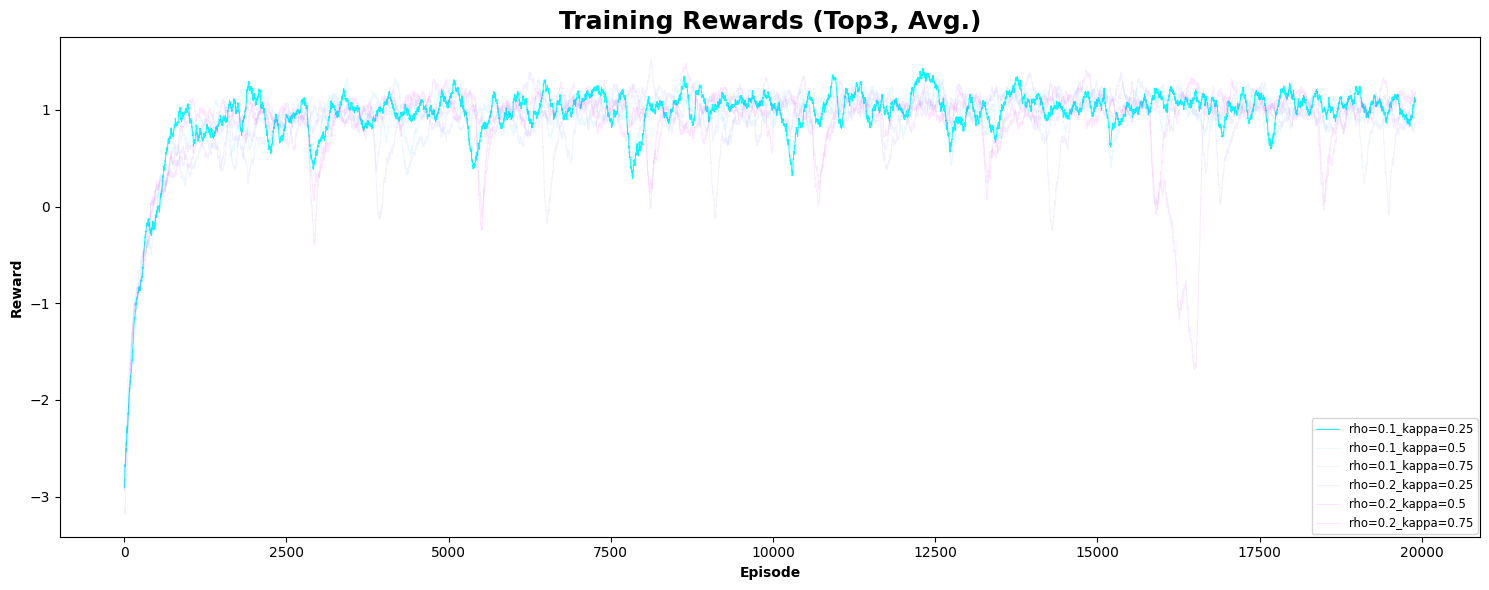

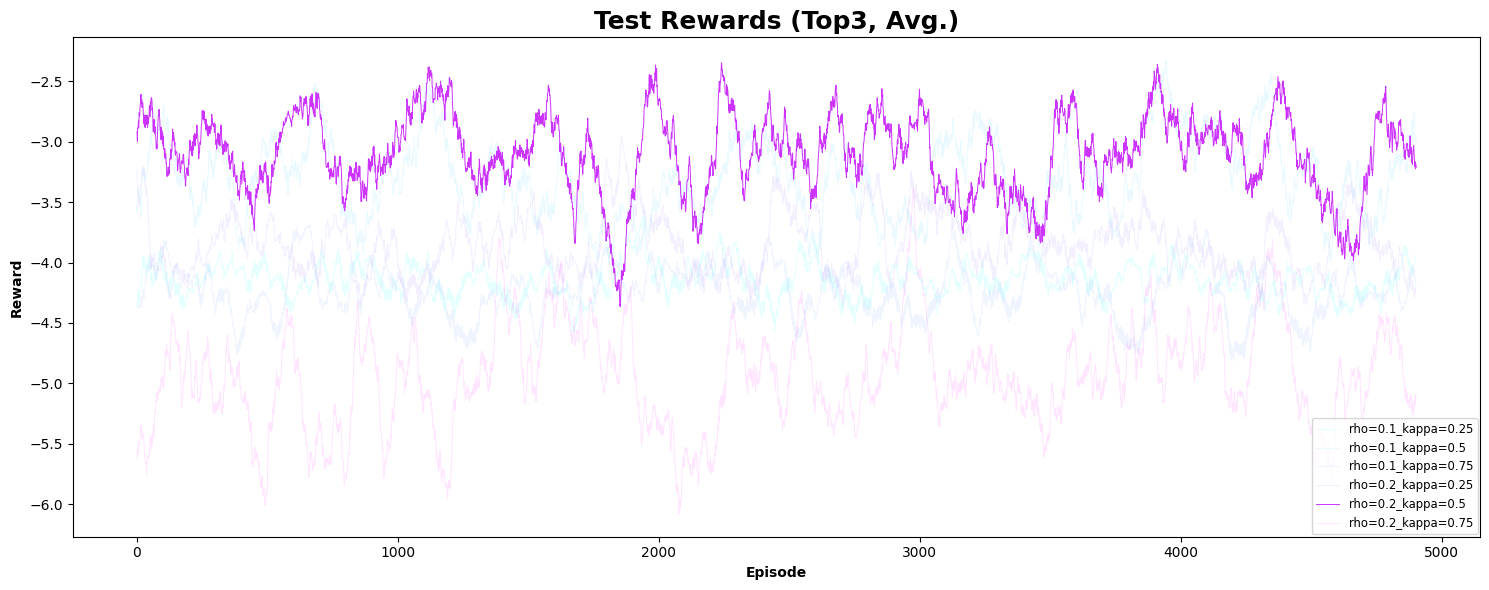

In [101]:


def smooth_data(data, window_size=5):
    """Apply a simple moving average smoothing to the data."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_rewards_with_opacity(rewards_dict, title, xlabel, ylabel, img_name):

    avg_rewards = {key: np.mean(rewards) for key, rewards in rewards_dict.items()} ##coefficients of variation
    top3_keys = sorted(avg_rewards, key=avg_rewards.get, reverse=True)[:1]
    
    

    fig, ax = plt.subplots(figsize=(15, 6))
    num_combinations = len(rewards_dict)
    cmap = cm.get_cmap("cool", num_combinations)
    
    # Loop through each hyperparameter combination and plot with a color from the colormap
    for idx, (key, rewards) in enumerate(rewards_dict.items()):

        smoothed_rewards = smooth_data(rewards, window_size=100)
        color = cmap(idx)  # Get the color for this hyperparameter combination
        # Adjust opacity for non-top3 combinations
        alpha = 1.0 if key in top3_keys else 0.1
        ax.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards, label=key, color=color, alpha=alpha,linewidth=0.7)
    
    # Set title with bold font
    ax.set_title(title, fontweight='bold',fontsize=18)
    ax.set_xlabel(xlabel,fontweight='bold')
    ax.set_ylabel(ylabel,fontweight='bold')
    
    
    ax.legend(loc='lower right', 
              bbox_to_anchor=(1.0, 0.0),  # Position the legend box outside to the right
              borderaxespad=0.2, 
              fancybox=True, 
              fontsize='small', 
              markerscale=0.5, 
            )  # Make the title bold
    fig.savefig(f'img/{img_name}.png',dpi=600) 
    plt.tight_layout()  # Ensures the legend does not get clipped
    plt.show()

# Plot for exp_res (training rewards)
plot_rewards_with_opacity(exp_res_DQN_pp, "Training Rewards (Top3, Avg.)", "Episode", "Reward","TR_rewards_avg_DQN_pp")

# Plot for test_res (test rewards)
plot_rewards_with_opacity(test_res_DQN_pp, "Test Rewards (Top3, Avg.)", "Episode", "Reward","Ts_rewards_avg_DQN_pp")


/tmp/ipykernel_24356/674433155.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("cool", num_combinations)


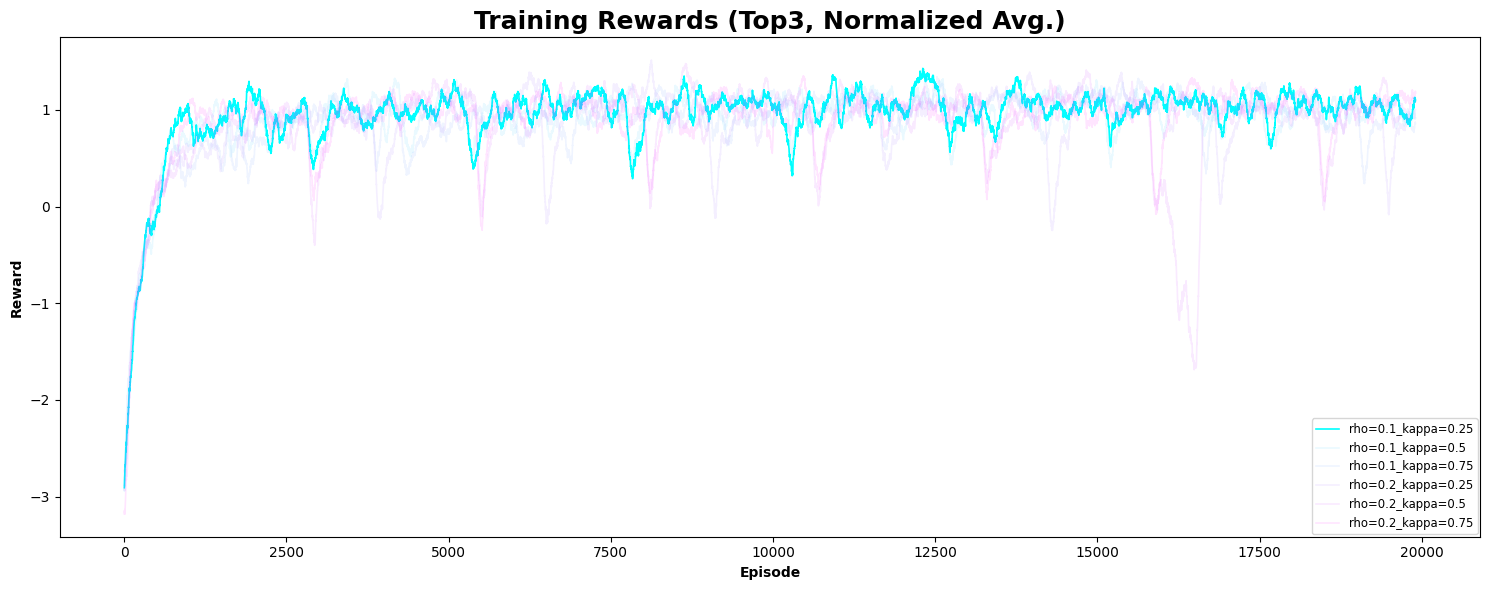

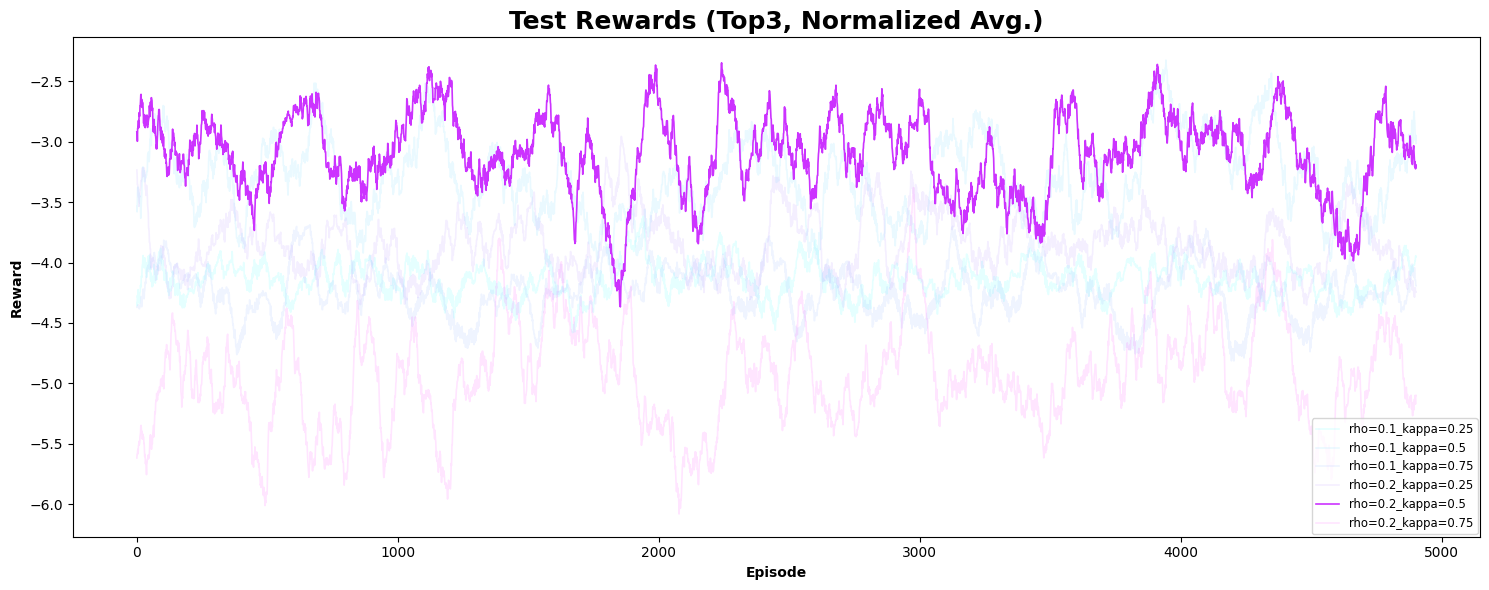

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties


def smooth_data(data, window_size=5):
    """Apply a simple moving average smoothing to the data."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_rewards_with_opacity(rewards_dict, title, xlabel, ylabel, img_name):
    # Calculate coefficients of variation
    cv_rewards = {key: np.mean(rewards)/np.std(rewards) for key, rewards in rewards_dict.items()}  
    top3_keys = sorted(cv_rewards, key=cv_rewards.get, reverse=True)[:1]
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(15, 6))
    num_combinations = len(rewards_dict)
    cmap = cm.get_cmap("cool", num_combinations)
    
    # Loop through each hyperparameter combination
    for idx, (key, rewards) in enumerate(rewards_dict.items()):
        # Smooth the rewards using moving average
        smoothed_rewards = smooth_data(rewards, window_size=100)
        
        # Choose a color for the line based on the index
        color = cmap(idx)
        
        # Adjust opacity for non-top3 combinations
        alpha = 1.0 if key in top3_keys else 0.1
        
        # Plot the smoothed data with a linewidth for visibility
        ax.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards, label=key, color=color, alpha=alpha, linewidth=1.2)
    
    # Set title with bold font
    ax.set_title(title, fontweight='bold', fontsize=18)
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    
    # # Create a FontProperties object for the legend title to make it bold
    # font_props = FontProperties(weight='bold')
    
    # Place the legend outside the figure on the middle-right
    ax.legend(loc='lower right', 
              bbox_to_anchor=(1.0, 0.0),  # Position the legend box outside to the right
              borderaxespad=0.2, 
              fancybox=True, 
              fontsize='small', 
              markerscale=0.5, 
            
              )  # Make the title bold
    
    # Save the figure and show the plot
    fig.savefig(f'img/{img_name}.png', dpi=600) 
    plt.tight_layout()  # Ensures the legend does not get clipped
    plt.show()

# Plot for exp_res (training rewards)
plot_rewards_with_opacity(exp_res_DQN_pp, "Training Rewards (Top3, Normalized Avg.)", "Episode", "Reward","TR_rewards_avg_DQN_pp_cv")

# Plot for test_res (test rewards)
plot_rewards_with_opacity(test_res_DQN_pp, "Test Rewards (Top3, Normalized Avg.)", "Episode", "Reward","Ts_rewards_avg_DQN_pp_cv")